In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import librosa
import librosa.display
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
def extract_mfcc_features(audio_path, n_mfcc=40, max_len=100):
    """
    Extrae características MFCC de un archivo de audio.
    
    Parámetros:
    - audio_path: ruta al archivo de audio
    - n_mfcc: número de coeficientes MFCC a extraer (40 es un buen estándar)
    - max_len: longitud máxima de frames para normalizar
    
    Retorna:
    - MFCC features normalizadas de forma (n_mfcc, max_len)
    """
    try:
        # Cargar audio
        wav, sr = librosa.load(audio_path, sr=16000)  # sr=16000 para normalizar frecuencia de muestreo
        
        # Extraer MFCC
        mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc)
        
        # Normalizar longitud mediante padding o truncado
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        
        return mfcc
    
    except Exception as e:
        print(f"Error procesando {audio_path}: {e}")
        return None

In [3]:
def parse_dataset(dataset_paths, n_mfcc=40, max_len=100, augment=False):
    X = []
    y = []
    class_names = []
    
    for index, dataset in enumerate(dataset_paths):
        class_name = os.path.basename(dataset)
        class_names.append(class_name)
        
        audio_files = [f for f in os.listdir(dataset) if f.endswith(('.wav', '.mp3', '.ogg'))]
        
        for i, fname in enumerate(audio_files):
            audio_path = os.path.join(dataset, fname)
            
            # Extraer features
            mfcc = extract_mfcc_features(audio_path, n_mfcc, max_len)
            
            if mfcc is not None:
                X.append(mfcc)
                y.append(index)
            
    X = np.array(X)
    y = np.array(y)
    
    print(f"\nDataset completo:")
    print(f"  Shape de X: {X.shape}")
    print(f"  Shape de y: {y.shape}")
    print(f"  Clases: {class_names}")
    
    return X, y, class_names

In [4]:
path = "./data/16000_pcm_speeches"
benjamin = os.path.join(path, "Benjamin_Netanyau")
jens = os.path.join(path, "Jens_Stoltenberg")
julia = os.path.join(path, "Julia_Gillard")
margaret = os.path.join(path, "Magaret_Tarcher")
nelson = os.path.join(path, "Nelson_Mandela")

In [5]:
X, y, class_names = parse_dataset([benjamin, jens, julia, margaret, nelson])


Dataset completo:
  Shape de X: (7501, 40, 100)
  Shape de y: (7501,)
  Clases: ['Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Magaret_Tarcher', 'Nelson_Mandela']


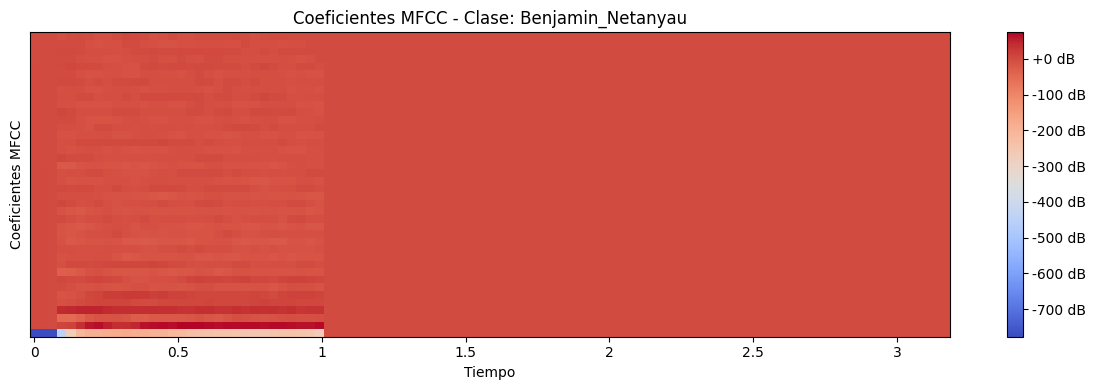

In [6]:
# Visualizar un ejemplo de MFCC
plt.figure(figsize=(12, 4))
librosa.display.specshow(X[0], x_axis='time', sr=16000)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Coeficientes MFCC - Clase: {class_names[y[0]]}')
plt.xlabel('Tiempo')
plt.ylabel('Coeficientes MFCC')
plt.tight_layout()
plt.show()

In [7]:
# Separar en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

Conjunto de entrenamiento: (6000, 40, 100)
Conjunto de prueba: (1501, 40, 100)


In [8]:
X_train_prep = X_train[..., np.newaxis]
X_test_prep = X_test[..., np.newaxis]

print(f"Shape final de X_train: {X_train_prep.shape}")
print(f"Shape final de X_test: {X_test_prep.shape}")

Shape final de X_train: (6000, 40, 100, 1)
Shape final de X_test: (1501, 40, 100, 1)


In [9]:
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Primer bloque convolucional
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Segundo bloque convolucional
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Tercer bloque convolucional
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Capas densas
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Capa de salida
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [10]:
model = build_cnn_model(input_shape=X_train_prep.shape[1:], num_classes=len(class_names))

In [ ]:
# Compilar el modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks para mejorar el entrenamiento
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [12]:
# Entrenar el modelo
history = model.fit(
    X_train_prep, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 223ms/step - accuracy: 0.7577 - loss: 0.6775 - val_accuracy: 0.8717 - val_loss: 0.3908 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 219ms/step - accuracy: 0.9588 - loss: 0.1330 - val_accuracy: 0.7925 - val_loss: 0.7062 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 34s 229ms/step - accuracy: 0.9679 - loss: 0.0967 - val_accuracy: 0.8267 - val_loss: 0.5831 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 34s 226ms/step - accuracy: 0.9777 - loss: 0.0661 - val_accuracy: 0.9975 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 237ms/step - accuracy: 0.9860 - loss: 0.0457 - val_accuracy: 0.9592 - val_loss: 0.1074 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - accuracy: 0.9842 - loss: 0.0451 - val_accuracy: 0.9950 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 34s 228ms/step - accuracy: 0.9

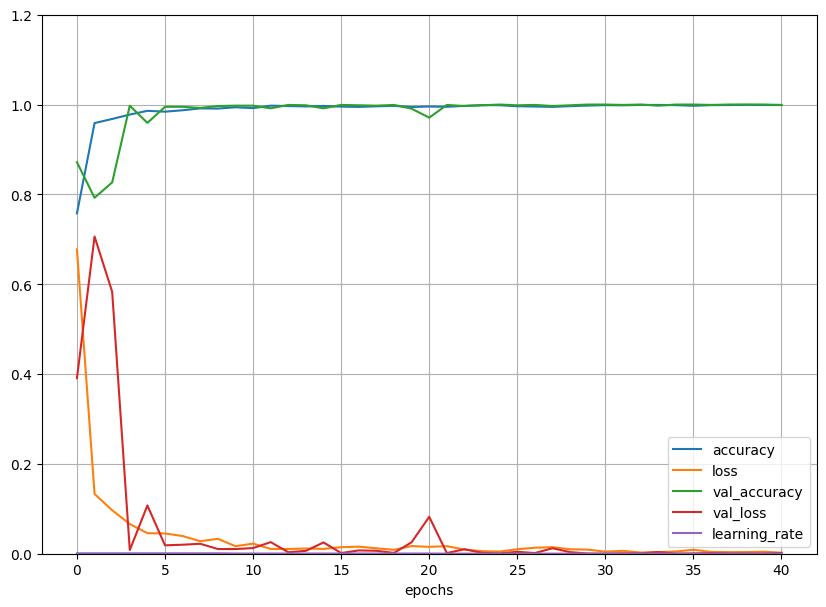

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

In [16]:
# Evaluar en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test_prep, y_test, verbose=0)
test_acc

1.0

In [17]:
# f1 score
from sklearn.metrics import f1_score
score = f1_score(y_test, np.argmax(model.predict(X_test_prep), axis=1), average='weighted')
score

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


1.0